<a href="https://colab.research.google.com/github/nicoaira/RNA-StruSiNet/blob/main/structure_triplets_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Instalations and imports

%%capture
!pip install forgi
!pip install igraph
!pip install ViennaRNA

import random
import string
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import forgi.visual.mplotlib as fvm
import forgi
from ViennaRNA import fold, RNA
import pandas as pd
from tqdm import tqdm
from google.colab import files
import math

In [ ]:
# @title Parameters

# @markdown Number of structures to be generated:
num_structures = 36000 # @param {type:"integer"}

# @markdown Size range for generated sequences:
seq_min_len = 80 # @param {type:"integer"}
seq_max_len = 220 # @param {type:"integer"}

# @markdown Distribution of generated sequence lenghts (normal/uniform):
seq_len_distribution = "norm" # @param ["norm", "unif"]

# @markdown Sequence lenght mean (only for normal distribution):
seq_len_mean = 156 # @param {type:"integer"}

# @markdown Sequence lenght std (only for normal distribution):
seq_len_sd = 33 # @param {type:"integer"}



# @markdown Number of rearregment cycles per structure:
rearrangements = 0 # @param {type:"integer"}


# @markdown Filename for the output csv:
out_file = 'dot_bracket_dummy_RNPs_triplets_1812.csv' # @param {type:"string"}

if seq_len_distribution == 'norm':
    assert(seq_min_len < seq_len_mean < seq_max_len)

In [ ]:
# @title Stem indels parameters

# @markdown Number of stems modification cycles:
n_stem_indels = 15 # @param {type:"integer"}

# @markdown Minimum possible size of stems before/after modification:
stem_min_size = 3 # @param {type:"integer"}

# @markdown Maximum amount of modifications in one stem:
stem_max_n_modifications = 4 # @param {type:"integer"}

In [ ]:
# @title Bulges indels parameters

# @markdown Number of bulge loops modification cycles:
n_bulge_indels = 13 # @param {type:"integer"}

# @markdown Minimum possible size of bulge loops before/after modification:
bulge_min_size = 1 # @param {type:"integer"}

# @markdown Maximum possible size of bulge loops before/after modification:
bulge_max_size = 12 # @param {type:"integer"}

# @markdown Maximum amount of modifications in one bulge loop:
bulge_max_n_modifications = 4 # @param {type:"integer"}

In [ ]:
# @title Hairpin loops indels parameters

# @markdown Number of hairpin loops modification cycles:
n_hloop_indels = 10 # @param {type:"integer"}

# @markdown Minimum possible size of hairpin loops before/after modification:
hloop_min_size = 4 # @param {type:"integer"}

# @markdown Maximum possible size of hairpin loops before/after modification:
hloop_max_size = 10 # @param {type:"integer"}

# @markdown Maximum amount of modifications in one hairpin loop:
hloop_max_n_modifications = 3 # @param {type:"integer"}

In [ ]:
# @title Internal loops indels parameters

# @markdown Number of internal loops modification cycles:
n_iloop_indels = 14 # @param {type:"integer"}

# @markdown Minimum possible size of internal loops (for each side) before/after modification:
iloop_min_size = 4 # @param {type:"integer"}

# @markdown Maximum possible size of internal loops (for each side) before/after modification:
iloop_max_size = 8 # @param {type:"integer"}

# @markdown Maximum amount of modifications (counting both sides) in one internal loop:
iloop_max_n_modifications = 3 # @param {type:"integer"}

In [ ]:
# @title Multiloops indels parameters

# @markdown Number of multi loops modification cycles:
n_mloop_indels = 7 # @param {type:"integer"}

# @markdown Minimum possible size of multi loops before/after modification:
mloop_min_size = 1 # @param {type:"integer"}

# @markdown Maximum possible size of multi loops before/after modification:
mloop_max_size = 10 # @param {type:"integer"}

# @markdown Maximum amount of modifications in one multi loop:
mloop_max_n_modifications = 3 # @param {type:"integer"}

In [ ]:
# @title Functions definitions

def update_nodes_dict(dot_bracket_mapper, nodes_dict):

    ''' This functions updates the nodes dict, which helps to map the range
    of each element of the strucutre, using the dot_bracket_mapper.
    There is a for loop that advances through the dot_bracket_mapper.
    In each step, it analyze wether
    '''

    updated_nodes_dict = {key : [] for key in nodes_dict.keys()}

    prev_element = 'START'

    for pos, element in enumerate(dot_bracket_mapper):

      if pos < len(dot_bracket_mapper) - 1:
        next_element = dot_bracket_mapper[pos+1]
      else:
        next_element = 'END'

      if element != prev_element:
        updated_nodes_dict[element].append(pos + 1)

      if element != next_element:
        updated_nodes_dict[element].append(pos + 1)

      prev_element = element


    for node, range in updated_nodes_dict.items():
      if range == []:
        updated_nodes_dict[node] = ''

    return updated_nodes_dict


def sequence_transformation(sequence,
                            case_found,
                            node_A_internals = None,
                            node_A_externals = None,
                            node_B_internals = None,
                            node_B_externals = None,
                            ):

    if case_found == 1 or case_found == 2:

        connector_1_range = ( node_A_internals[0] + 1 , node_B_externals[0] - 1 )
        connector_2_range = ( node_B_externals[1] + 1 , node_A_internals[1] - 1 )

        sequence_temp  = sequence[ :node_A_internals[0]]
        sequence_temp += sequence[connector_2_range[0] - 1 : connector_2_range[1]]
        sequence_temp += sequence[node_B_externals[0] - 1 : node_B_externals[1]]
        sequence_temp += sequence[connector_1_range[0] - 1 : connector_1_range[1]]
        sequence_temp += sequence[node_A_internals[1] - 1 : ]

    elif case_found == 3 or case_found == 4:

        connector_range = ( node_A_externals[1] + 1 , node_B_externals[0] - 1 )

        sequence_temp  = sequence[:node_A_externals[0] - 1]
        sequence_temp += sequence[node_B_externals[0] - 1 : node_B_externals[1]]
        sequence_temp += sequence[connector_range[0] - 1 : connector_range[1]]
        sequence_temp += sequence[node_A_externals[0] - 1 : node_A_externals[1]]
        sequence_temp += sequence[node_B_externals[1]:]

    return sequence_temp


def structure_shuffle(shuffled_structure, node1, node2, graph,
                      nodes_dict, dot_bracket_mapper):



    node_1_name = graph.vs['name'][node_1]
    node_1_range = (nodes_dict[node_1_name][1], nodes_dict[node_1_name][2])

    node_2_name = graph.vs['name'][node_2]
    node_2_range = (nodes_dict[node_2_name][0], nodes_dict[node_2_name][3])

    node_1_internals = ( nodes_dict[node_1_name][1] , nodes_dict[node_1_name][2] )
    node_1_externals = ( nodes_dict[node_1_name][0] , nodes_dict[node_1_name][3] )

    node_2_internals = ( nodes_dict[node_2_name][1] , nodes_dict[node_2_name][2] )
    node_2_externals = ( nodes_dict[node_2_name][0] , nodes_dict[node_2_name][3] )

    ## Two possible scenarios for the swapping:
    ## 1 -  Both structures to swap are independent, i.e., node_1 and node_2 ranges are not overlapping
    ## 2 -  One of the structures is inside the range of the other one. This is, the
    ##      structure_2_start

    if node_1_externals[0] < node_2_externals[0] and node_1_externals[1] > node_2_externals[1]:

        case_found = 1

        # node_1 = A
        # node_2 = B

        node_A_internals = node_1_internals
        node_A_externals = node_1_externals

        node_B_internals = node_2_internals
        node_B_externals = node_2_externals

    elif node_2_externals[0] < node_1_externals[0] and node_2_externals[1] > node_1_externals[1]:

        case_found = 2

        # node_2 = A
        # node_1 = B

        node_A_internals = node_2_internals
        node_A_externals = node_2_externals

        node_B_internals = node_1_internals
        node_B_externals = node_1_externals

    elif node_1_externals[1] < node_2_externals[0]:

        case_found = 3

        # node_1 = A
        # node_2 = B

        node_A_internals = node_1_internals
        node_A_externals = node_1_externals

        node_B_internals = node_2_internals
        node_B_externals = node_2_externals


    elif node_2_externals[1] < node_1_externals[0]:

        case_found = 4

        # node_2 = A
        # node_1 = B

        node_A_internals = node_2_internals
        node_A_externals = node_2_externals

        node_B_internals = node_1_internals
        node_B_externals = node_1_externals



    shuffled_structure = sequence_transformation(shuffled_structure,
                                                 case_found,
                                                 node_A_internals,
                                                 node_A_externals,
                                                 node_B_internals,
                                                 node_B_externals)


    dot_bracket_mapper = sequence_transformation(dot_bracket_mapper,
                                                 case_found,
                                                 node_A_internals,
                                                 node_A_externals,
                                                 node_B_internals,
                                                 node_B_externals)

    return shuffled_structure, dot_bracket_mapper


def stem_indels(dot_bracket_mapper,
                structure,
                modifications_counter,
                min_size = 3,
                max_modifications=np.inf):

  ''' Takes a stucture and a dot_bracket_mapper and randomly makes an insertion
  or deletion in one the stems of the structure. The chance of selection of a
  stem is proportional of to its size. There is a possibility to set a min size
  of a stem to be modified.
  '''

  elements_sizes = {key : 0 for key in dot_bracket_mapper}

  for element in elements_sizes.keys():
      elements_sizes[element] = dot_bracket_mapper.count(element)

  stem_sizes = {key : value for key, value in elements_sizes.items() if (key.startswith('s') and min_size < value/2 )}

  # If there are no stems with size > min_size, then return the unaffected structure

  if not stem_sizes:
    return dot_bracket_mapper, structure, modifications_counter

  total_value = sum(stem_sizes.values())

  ## Randomly select an stem with a probability proportional to its size

  random_num = random.randint(0, total_value - 1)

  # Iterate through the dictionary to find the key corresponding to the random number
  for stem, size in stem_sizes.items():
      random_num -= size
      if random_num < 0:
          selected_stem = stem
          break

  # If the selected stem already suffered the max number of modifications, then
  # it returns the unaffected structure
  if modifications_counter[selected_stem] == max_modifications:
      return dot_bracket_mapper, structure, modifications_counter

  else:
      pass

  modifications_counter[selected_stem] += 1

  options = ['insert', 'delete']
  selected_option = random.choice(options)

  if selected_option == 'delete':
    # Find the index of the first occurrence of the element
    first_index = dot_bracket_mapper.index(selected_stem)

    # Find the index of the last occurrence of the element
    last_index = len(dot_bracket_mapper) - dot_bracket_mapper[::-1].index(selected_stem) - 1

    dot_bracket_mapper.pop(first_index)
    structure = structure[:first_index] + structure[first_index+1:]

    # we need to modify the last_index since the structure has been shorten in 1
    last_index -= 1

    dot_bracket_mapper.pop(last_index)
    structure = structure[:last_index] + structure[last_index+1:]


  if selected_option == 'insert':
    # Find the index of the first occurrence of the element
    first_index = dot_bracket_mapper.index(selected_stem)

    # Find the index of the last occurrence of the element
    last_index = len(dot_bracket_mapper) - dot_bracket_mapper[::-1].index(selected_stem) - 1

    dot_bracket_mapper.insert(first_index, selected_stem)
    structure = structure[:first_index] + '(' + structure[first_index:]

    # we need to modify the last_index since the structure has been enlargen in 1
    last_index += 1
    dot_bracket_mapper.insert(last_index+1, selected_stem)
    structure = structure[:last_index] + ')' + structure[last_index:]


  return dot_bracket_mapper, structure, modifications_counter


def hairpin_loop_indels(dot_bracket_mapper,
                        structure,
                        modifications_counter,
                        min_size = 4,
                        max_size = 8,
                        max_modifications=np.inf):

  ''' Takes a stucture and a dot_bracket_mapper and randomly makes an insertion
  or deletion in one the hairpin loops of the structure.
  There is a possibility to set a min and max size of a hairpin to be modified.
  '''

  elements_sizes = {key : 0 for key in dot_bracket_mapper}

  for element in elements_sizes.keys():
      elements_sizes[element] = dot_bracket_mapper.count(element)

  loops_sizes = {key : value for key, value in elements_sizes.items() if (key.startswith('h') and min_size <= value <= max_size)}

  # If there are no loops with min_size < size < max_size, then return the
  # unaffected structure

  if not loops_sizes:
    return dot_bracket_mapper, structure, modifications_counter

  selected_loop = random.choice(list(loops_sizes.keys()))

  # If the selected loop already suffered the max number of modifications, then
  # it returns the unaffected structure
  if modifications_counter[selected_loop] == max_modifications:
      return dot_bracket_mapper, structure, modifications_counter
  else:
      pass

  options = ['insert', 'delete']
  selected_option = random.choice(options)

  modifications_counter[selected_loop] += 1

  # Make sure the modification does not make the loop to pass the limits
  if (loops_sizes[selected_loop] == min_size and selected_option == 'delete') \
   or (loops_sizes[selected_loop] == max_size and selected_option == 'insert'):
    return dot_bracket_mapper, structure, modifications_counter
  else:
    pass

  if selected_option == 'delete':
    # Find the index of the first occurrence of the element
    first_index = dot_bracket_mapper.index(selected_loop)

    dot_bracket_mapper.pop(first_index)
    structure = structure[:first_index] + structure[first_index+1:]

  if selected_option == 'insert':
    # Find the index of the first occurrence of the element
    first_index = dot_bracket_mapper.index(selected_loop)

    dot_bracket_mapper.insert(first_index, selected_loop)
    structure = structure[:first_index] + '.' + structure[first_index:]


  return dot_bracket_mapper, structure, modifications_counter


def internal_loop_indels(dot_bracket_mapper,
                         structure,
                         modifications_counter,
                         nodes_dict,
                         internal_loops_list,
                         min_size = 1,
                         max_size = 8,
                         max_modifications=np.inf):

  ''' Takes a stucture and a dot_bracket_mapper and randomly makes an insertion
  or deletion in one the internal loops of the structure.
  There is a possibility to set a min and max size of a loop to be modified.
  '''

  loop_sizes = {}
  # this dictionary will store the size of all the loop that are within the
  # range for modifications. It will diffirenciate both sides of the loop
  for loop in internal_loops_list:

    loop_ranges = nodes_dict[loop]
    loop_A = loop_ranges[:2] # range of the loop at the 5' side
    loop_A_size = loop_A[1] - loop_A[0] + 1
    if min_size <= loop_A_size <= max_size:
      loop_sizes[loop+'-A'] = loop_A_size

    loop_B = loop_ranges[2:] # range of the loop at the 3' side
    loop_B_size = loop_B[1] - loop_B[0] + 1
    if min_size <= loop_B_size <= max_size:
      loop_sizes[loop+'-B'] = loop_B_size


  # If there are no loops with min_size < size < max_size, then return the
  # unaffected structure

  if not loop_sizes:
    return dot_bracket_mapper, structure, modifications_counter

  selected_loop = random.choice(list(loop_sizes.keys()))

  selected_side = selected_loop.split('-')[1] # A or B (5' or 3' side of the loop)

  selected_loop_code = selected_loop.split('-')[0] # the element code (e.g. i3)

  # If the selected bluge already suffered the max number of modifications, then
  # it returns the unaffected structure

  if modifications_counter[selected_loop] == max_modifications:
      return dot_bracket_mapper, structure, modifications_counter
  else:
      pass

  options = ['insert', 'delete']
  selected_option = random.choice(options)

  modifications_counter[selected_loop] += 1

  # Make sure the modification does not make the loop to pass the limits
  if (loop_sizes[selected_loop] == min_size and selected_option == 'delete') \
   or (loop_sizes[selected_loop] == max_size and selected_option == 'insert'):
    return dot_bracket_mapper, structure, modifications_counter
  else:
    pass


  if selected_option == 'delete':
    if selected_side == 'A':
      # Find the index of the first occurrence of the element
      first_index = dot_bracket_mapper.index(selected_loop_code)

      dot_bracket_mapper.pop(first_index)
      structure = structure[:first_index] + structure[first_index+1:]

    elif selected_side == 'B':
      # Find the index of the last occurrence of the element
      last_index = dot_bracket_mapper[::-1].index(selected_loop_code)  # Reverse the list and find the index
      last_index = len(dot_bracket_mapper) - last_index - 1  # Adjust the index to the original list

      dot_bracket_mapper.pop(last_index)
      structure = structure[:last_index] + structure[last_index+1:]

  elif selected_option == 'insert':
    if selected_side == 'A':
      # Find the index of the first occurrence of the element
      first_index = dot_bracket_mapper.index(selected_loop_code)

      dot_bracket_mapper.insert(first_index, selected_loop_code)
      structure = structure[:first_index] + '.' + structure[first_index:]

    elif selected_side == 'B':
      # Find the index of the last occurrence of the element
      last_index = dot_bracket_mapper[::-1].index(selected_loop_code)  # Reverse the list and find the index
      last_index = len(dot_bracket_mapper) - last_index - 1  # Adjust the index to the original list

      dot_bracket_mapper.insert(last_index, selected_loop_code)

      structure = structure[:last_index] + '.' + structure[last_index:]


  return dot_bracket_mapper, structure, modifications_counter


def bulge_indels(dot_bracket_mapper,
                 structure,
                 modifications_counter,
                 bulges_list,
                 min_size = 1,
                 max_size = 8,
                 max_modifications=np.inf):

  ''' Takes a stucture and a dot_bracket_mapper and randomly makes an insertion
  or deletion in one the bulges of the structure.
  There is a possibility to set a min and max size of a hairpin to be modified.
  '''

  elements_sizes = {key : 0 for key in dot_bracket_mapper}

  for element in elements_sizes.keys():
      elements_sizes[element] = dot_bracket_mapper.count(element)

  bulges_sizes = {key : value for key, value in elements_sizes.items() if (key in bulges_list and min_size <= value <= max_size)}

  # If there are no bulges with min_size < size < max_size, then return the
  # unaffected structure


  if not bulges_sizes:
    return dot_bracket_mapper, structure, modifications_counter

  selected_bulge = random.choice(list(bulges_sizes.keys()))

  # If the selected bluge already suffered the max number of modifications, then
  # it returns the unaffected structure

  if modifications_counter[selected_bulge] == max_modifications:
      return dot_bracket_mapper, structure, modifications_counter
  else:
      pass

  options = ['insert', 'delete']
  selected_option = random.choice(options)

  modifications_counter[selected_bulge] += 1

  # Make sure the modification does not make the loop to pass the limits
  if (bulges_sizes[selected_bulge] == min_size and selected_option == 'delete') \
   or (bulges_sizes[selected_bulge] == max_size and selected_option == 'insert'):
    return dot_bracket_mapper, structure, modifications_counter
  else:
    pass

  if selected_option == 'delete':
    # Find the index of the first occurrence of the element
    first_index = dot_bracket_mapper.index(selected_bulge)

    dot_bracket_mapper.pop(first_index)
    structure = structure[:first_index] + structure[first_index+1:]

  if selected_option == 'insert':
    # Find the index of the first occurrence of the element
    first_index = dot_bracket_mapper.index(selected_bulge)

    dot_bracket_mapper.insert(first_index, selected_bulge)
    structure = structure[:first_index] + '.' + structure[first_index:]


  return dot_bracket_mapper, structure, modifications_counter


def multi_loop_indels(dot_bracket_mapper,
                      structure,
                      modifications_counter,
                      min_size = 0,
                      max_size = 10,
                      max_modifications=np.inf):

  ''' Takes a stucture and a dot_bracket_mapper and randomly makes an insertion
  or deletion in one the multisegment loops of the structure.
  There is a possibility to set a min and max size of a  multisegment loops
  to be modified.
  '''

  elements_sizes = {key : 0 for key in dot_bracket_mapper}

  for element in elements_sizes.keys():
      elements_sizes[element] = dot_bracket_mapper.count(element)

  mloops_sizes = {key : value for key, value in elements_sizes.items() if (key.startswith('m') and min_size <= value <= max_size)}

  # If there are no mloops with min_size < size < max_size, then return the
  # unaffected structure

  if not mloops_sizes:
    return dot_bracket_mapper, structure, modifications_counter

  selected_mloop = random.choice(list(mloops_sizes.keys()))

  # If the selected loop already suffered the max number of modifications, then
  # it returns the unaffected structure
  if modifications_counter[selected_mloop] == max_modifications:
      return dot_bracket_mapper, structure, modifications_counter
  else:
      pass

  options = ['insert', 'delete']
  selected_option = random.choice(options)

  modifications_counter[selected_mloop] += 1

  # Make sure the modification does not make the loop to pass the limits
  if (mloops_sizes[selected_mloop] == min_size and selected_option == 'delete') \
   or (mloops_sizes[selected_mloop] == max_size and selected_option == 'insert'):
    return dot_bracket_mapper, structure, modifications_counter
  else:
    pass

  first_index = dot_bracket_mapper.index(selected_mloop)
  if structure[first_index] != '.':
    return dot_bracket_mapper, structure, modifications_counter

  if selected_option == 'delete':
    # Find the index of the first occurrence of the element

    dot_bracket_mapper.pop(first_index)
    structure = structure[:first_index] + structure[first_index+1:]

  if selected_option == 'insert':
    # Find the index of the first occurrence of the element

    dot_bracket_mapper.insert(first_index, selected_mloop)
    structure = structure[:first_index] + '.' + structure[first_index:]

  return dot_bracket_mapper, structure, modifications_counter


def generate_negative_structure(anchor_sequence):
  '''This function takes the random sequence to
  be used as anchor during triplets training and
  generate a random negative structure thas has
  the same lenght and gc content than the anchor,
  to prevent bias'''

  anchor_list = list(anchor_sequence)
  random.shuffle(anchor_list)
  negative_sequence = ''.join(anchor_list)

  # Enlarge or shrink sequence by +-5%
  max_change = 0.05
  change_franction = random.uniform(-max_change, max_change)
  change_length = round(int(change_franction*len(anchor_list)))

  if change_length == 0:
    mod_negative_sequence = negative_sequence

  if change_length < 0:
    # Randomly pick and remove letters from the list
    random_indexes = random.sample(range(len(negative_sequence)), abs(change_length))
    # Create a new string without the randomly picked letters
    negative_list = list(negative_sequence)
    [negative_list.pop(index) for index in sorted(random_indexes, reverse=True)]

    mod_negative_sequence = ''.join(negative_list)

  if change_length > 0:
    # Choose random letters from the original string
    bases_to_add = random.sample(negative_sequence, change_length)

    # Convert the original string to a list for easy insertion
    negative_list = list(negative_sequence)

    # Insert the random letters at random positions
    for base in bases_to_add:
        position = random.randint(0, len(negative_list))
        negative_list.insert(position, base)

    # Convert the list back to a string
    mod_negative_sequence = ''.join(negative_list)

  negative_structure, _ = fold(mod_negative_sequence)

  return negative_structure

In [ ]:
# @title Pairs generation loop

structure_triplets = []
counter = num_structures

with tqdm(total=num_structures, desc="Processing") as pbar:
    while counter > 0:

        if seq_len_distribution == 'unif':
            seq_len = random.randint(seq_min_len, seq_max_len)

        elif seq_len_distribution == 'norm':

            while True:
                seq_len = int(np.random.normal(seq_len_mean, seq_len_sd))
                if seq_min_len <= seq_len <= seq_max_len:
                    break

        # Generate a random RNA sequence
        rna_sequence = ''.join(random.choice("ACGU") for _ in range(seq_len))

        # Predict the minimum free energy (MFE) secondary structure
        mfe_structure, _ = fold(rna_sequence)

        cg = forgi.load_rna(mfe_structure, allow_many=False)

        graph_description = cg.to_bg_string()

        nodes_dict = {}
        edges_list = []

        lines = graph_description.splitlines()

        for line in lines:
            if line.startswith('define'):
              node_list = line.strip('define').split()
              if len(node_list) > 1:
                nodes_dict[node_list[0]] = [int(str_base) for str_base in node_list[1:]]
              else:
                nodes_dict[node_list[0]] = ''


        neato_rna = cg.to_neato_string()
        lines = neato_rna.splitlines()

        for line in lines[:]:
          if '--' in line:
            edge = line.strip(';').strip().split(' -- ')
            edges_list.append(edge)


        # We need to create a mapping for every element in the dot_bracket structure
        # Later, when we shuffle the sequence, we will apply the same transformations
        # to this mapper in order to keep track of the position of every element in
        # the resulting shuffled strucute. Then, we will use this mapping to update the
        # nodes_dict, needed to shuffle the strucutre.

        dot_bracket_mapper = [0 for i in mfe_structure]

        for node_name, node_range in nodes_dict.items():
          if len(node_range) == 2:
            range_start = node_range[0] - 1
            range_end = node_range[1] - 1
            for ix in range(range_start, range_end + 1):
              dot_bracket_mapper[ix] = node_name

          elif len(node_range) == 4:
            left_range_start = node_range[0] - 1
            left_range_end = node_range[1] - 1

            for ix in range(left_range_start, left_range_end + 1):
                dot_bracket_mapper[ix] = node_name

            right_range_start = node_range[2] - 1
            right_range_end = node_range[3] - 1

            for ix in range(right_range_start, right_range_end + 1):
                dot_bracket_mapper[ix] = node_name

        edges_dict = {edge[0] : [] for edge in edges_list}

        for edge in edges_list:
          edges_dict[edge[0]].append(edge[1])

        g = ig.Graph.ListDict(edges_dict, directed = False)


        """# Shuffle"""

        shuffled_structure = mfe_structure
        g2 = g.copy()

        multiloops = []

        for multiloop in cg.junctions:
            if not any(not element.startswith('m') for element in multiloop) and \
                len(multiloop) > 1:
                multiloops.append(multiloop)

        if rearrangements == 0:
          # This prevents infinit loop when rearrangements is 0
          shuffled = True
        else:
          shuffled = False

        for shuffle_step in range(rearrangements):

            if len(multiloops) < 1:
                break
            else:
                shuffled = True

            random_multiloop = random.choice(multiloops)
            random_loop = random.choice(random_multiloop)

            m_neighbors = g2.neighbors(random_loop)

            try:

                node_1 = m_neighbors[0]
                node_1_neighbors = g2.neighbors(node_1)

                node_1_loop_neighbors = []
                for neighbor_ix in node_1_neighbors:
                    neighbor_name = g2.vs['name'][neighbor_ix]
                    if neighbor_name in random_multiloop:
                        node_1_loop_neighbors.append(neighbor_name)

                node_2 = m_neighbors[1]
                node_2_neighbors = g2.neighbors(node_2)

                node_2_loop_neighbors = []
                for neighbor_ix in node_2_neighbors:
                    neighbor_name = g2.vs['name'][neighbor_ix]
                    if neighbor_name in random_multiloop:
                        node_2_loop_neighbors.append(neighbor_name)

                # Removing edges node 1
                g2.delete_edges([(node_1, node_1_loop_neighbors[0])])
                g2.delete_edges([(node_1, node_1_loop_neighbors[1])])

                # Removing edges node 2
                g2.delete_edges([(node_2, node_2_loop_neighbors[0])])
                g2.delete_edges([(node_2, node_2_loop_neighbors[1])])

                # Add new edges node 1
                g2.add_edge(node_1, node_2_loop_neighbors[0])
                g2.add_edge(node_1, node_2_loop_neighbors[1])

                # Add new edges node 2
                g2.add_edge(node_2, node_1_loop_neighbors[0])
                g2.add_edge(node_2, node_1_loop_neighbors[1])

                shuffled_structure, dot_bracket_mapper = structure_shuffle(shuffled_structure,
                                                                           node_1,
                                                                           node_2,
                                                                           g2,
                                                                           nodes_dict,
                                                                           dot_bracket_mapper)

                nodes_dict = update_nodes_dict(dot_bracket_mapper, nodes_dict)

                shuffled = True
                assert(len(shuffled_structure) == len(mfe_structure))


            except IndexError:
                shuffled = False


        ## Two possible scenarios for the swapping:
        ## 1 -  Both structures to swap are independent, i.e., node_1 and node_2 ranges are not overlapping
        ## 2 -  One of the structures is inside the range of the other one. This is, the
        ##      structure_2_start

        if shuffled:

            bulges_list = []
            internal_loops_list = []
            for node in nodes_dict.keys():
              if node.startswith('i'):
                if len(nodes_dict[node]) == 2:
                  # Node is a bulge
                  bulges_list.append(node)

                elif len(nodes_dict[node]) == 4:
                  # Node is an internal loop
                  internal_loops_list.append(node)
              else:
                pass


            modifications_counter = {key : 0 for key in dot_bracket_mapper}
            for internal_loop in internal_loops_list:
              modifications_counter[internal_loop+'-A'] = 0
              modifications_counter[internal_loop+'-B'] = 0
              modifications_counter.pop(internal_loop)

            for i in range(n_stem_indels):

              dot_bracket_mapper, shuffled_structure, modifications_counter = stem_indels(dot_bracket_mapper,
                                                                                          shuffled_structure,
                                                                                          modifications_counter,
                                                                                          min_size = stem_min_size,
                                                                                          max_modifications=stem_max_n_modifications)



            for i in range(n_hloop_indels):

              dot_bracket_mapper, shuffled_structure, modifications_counter = hairpin_loop_indels(dot_bracket_mapper,
                                                                                                  shuffled_structure,
                                                                                                  modifications_counter,
                                                                                                  min_size = hloop_min_size,
                                                                                                  max_size = hloop_max_size,
                                                                                                  max_modifications=hloop_max_n_modifications)


            for i in range(n_iloop_indels):

              nodes_dict = update_nodes_dict(dot_bracket_mapper, nodes_dict)

              dot_bracket_mapper, shuffled_structure, modifications_counter = internal_loop_indels(dot_bracket_mapper,
                                                                                                   shuffled_structure,
                                                                                                   modifications_counter,
                                                                                                   nodes_dict,
                                                                                                   internal_loops_list,
                                                                                                   min_size = iloop_min_size,
                                                                                                   max_size = iloop_max_size,
                                                                                                   max_modifications=iloop_max_n_modifications)

            for i in range(n_bulge_indels):

              dot_bracket_mapper, shuffled_structure, modifications_counter = bulge_indels(dot_bracket_mapper,
                                                                                           shuffled_structure,
                                                                                           modifications_counter,
                                                                                           bulges_list,
                                                                                           min_size = bulge_min_size,
                                                                                           max_size = bulge_max_size,
                                                                                           max_modifications=bulge_max_n_modifications)



            for i in range(n_mloop_indels):

              dot_bracket_mapper, shuffled_structure, modifications_counter = multi_loop_indels(dot_bracket_mapper,
                                                                                                shuffled_structure,
                                                                                                modifications_counter,
                                                                                                min_size = mloop_min_size,
                                                                                                max_size = mloop_max_size,
                                                                                                max_modifications=mloop_max_n_modifications)



            counter -= 1



            ##### Generate negative structure

            neg_structure = generate_negative_structure(rna_sequence)

            structure_triplets.append((mfe_structure, shuffled_structure, neg_structure))

            pbar.update(1)


print('\n'+str(num_structures)+" structure pairs generated")

Processing: 100%|██████████| 36000/36000 [44:34<00:00, 13.46it/s]


36000 structure pairs generated


In [ ]:
# @title Create and download dataset
df = pd.DataFrame(structure_triplets, columns=['structure_A', 'structure_P', 'structure_N'])

# Write the DataFrame to a CSV file
print(out_file, 'created!')
df.to_csv(out_file, index=False)

# files.download(out_file)

dot_bracket_dummy_RNPs_triplets_1812.csv created!


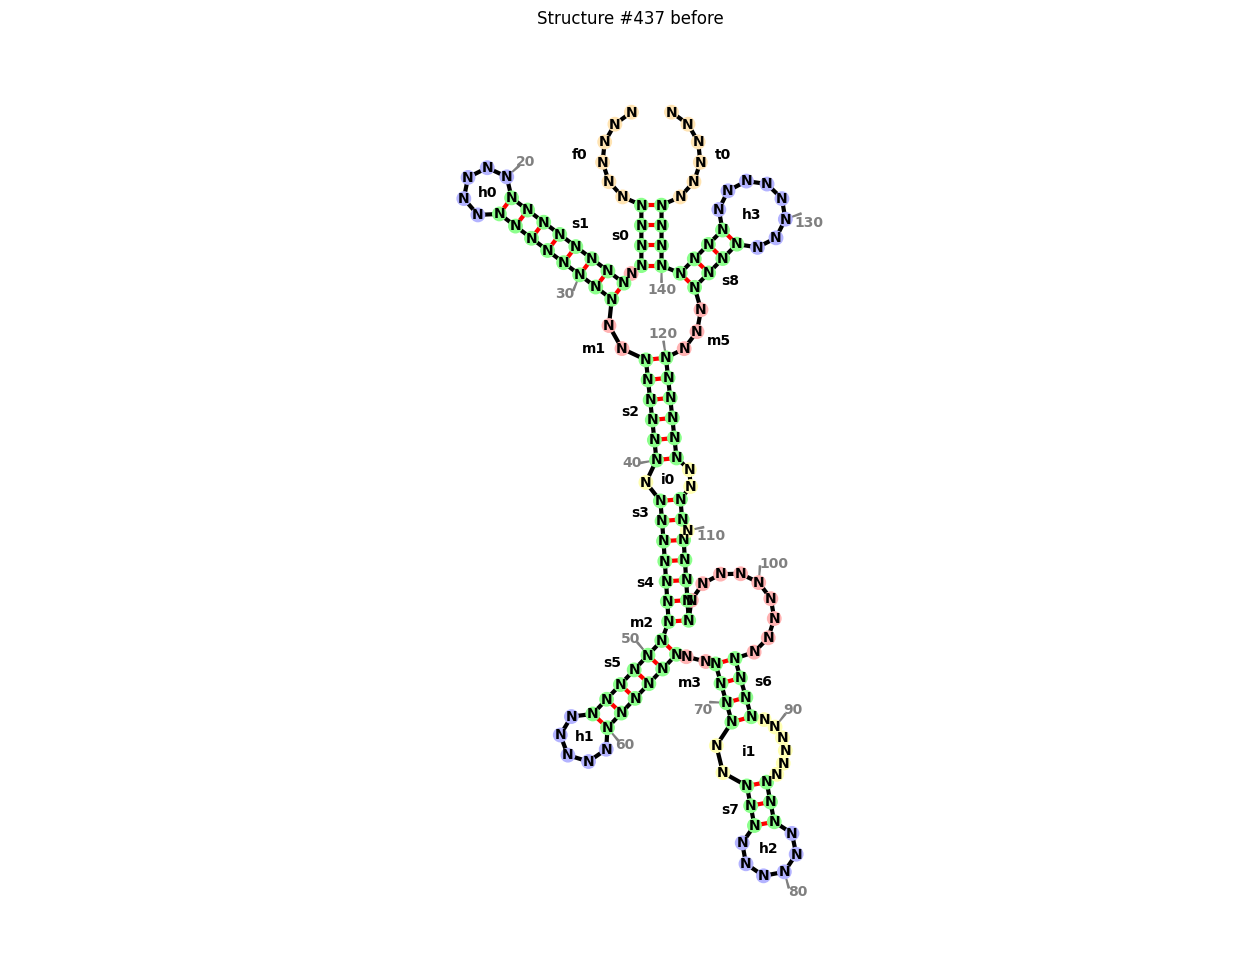

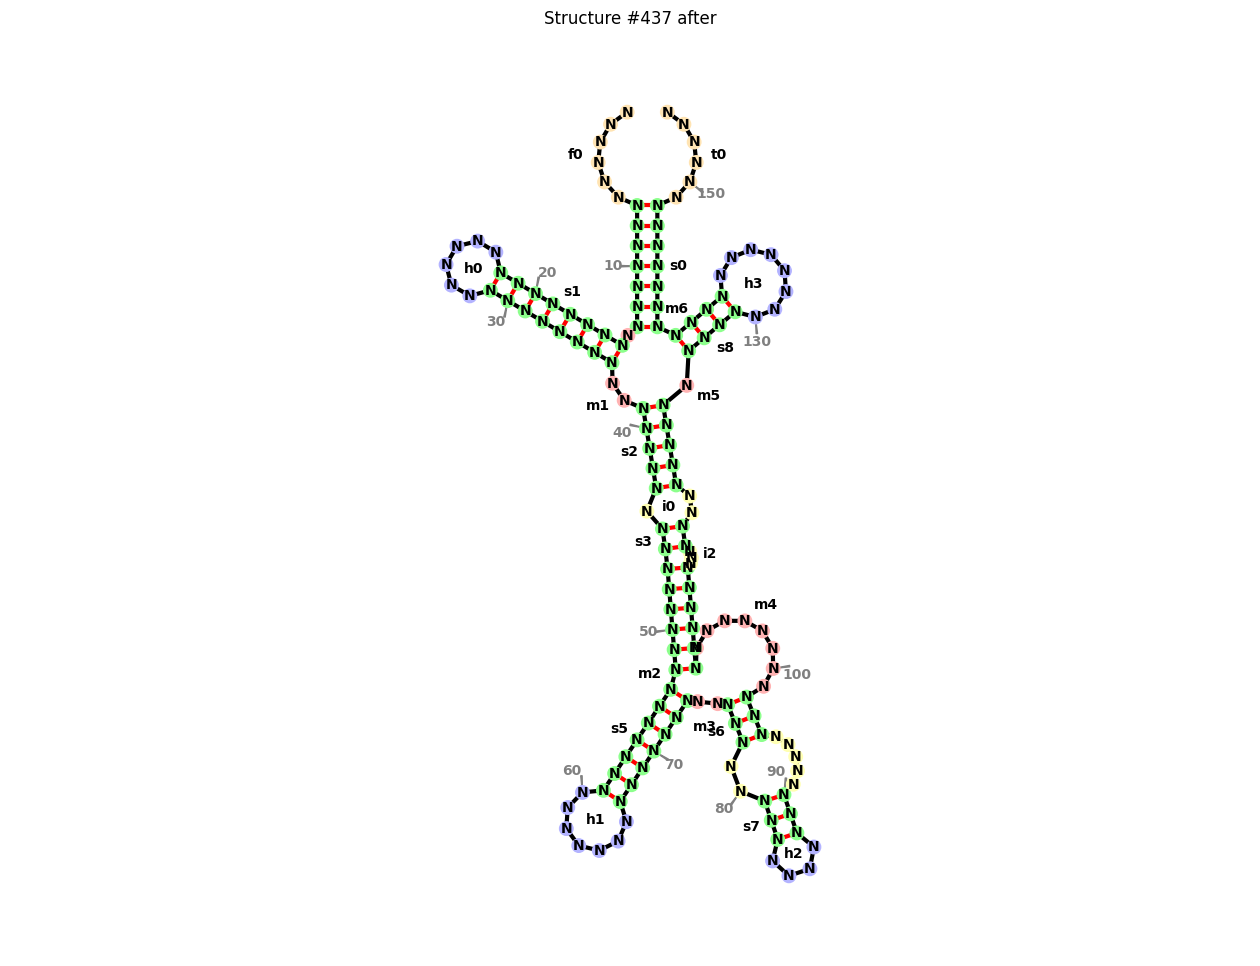

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




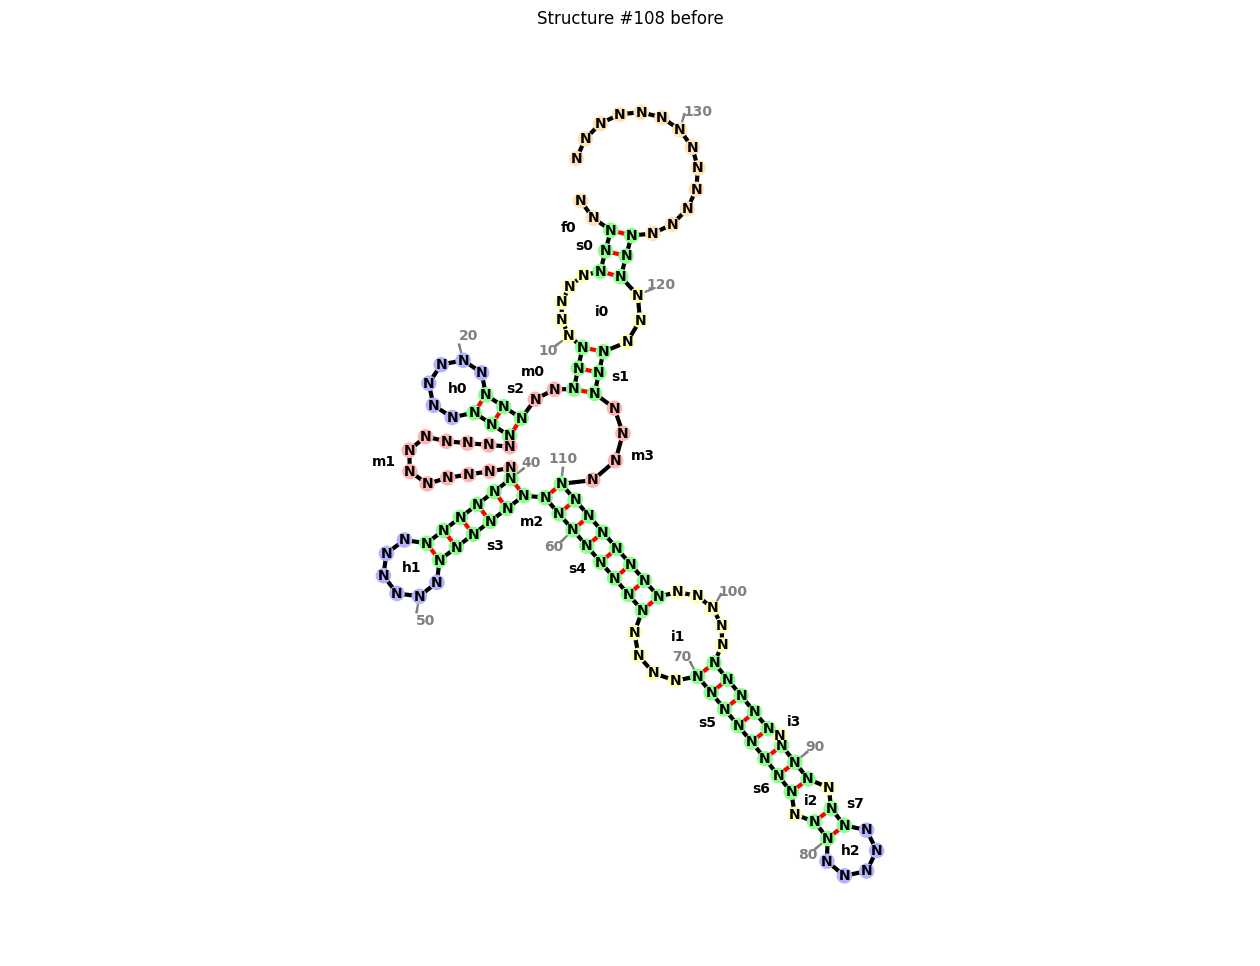

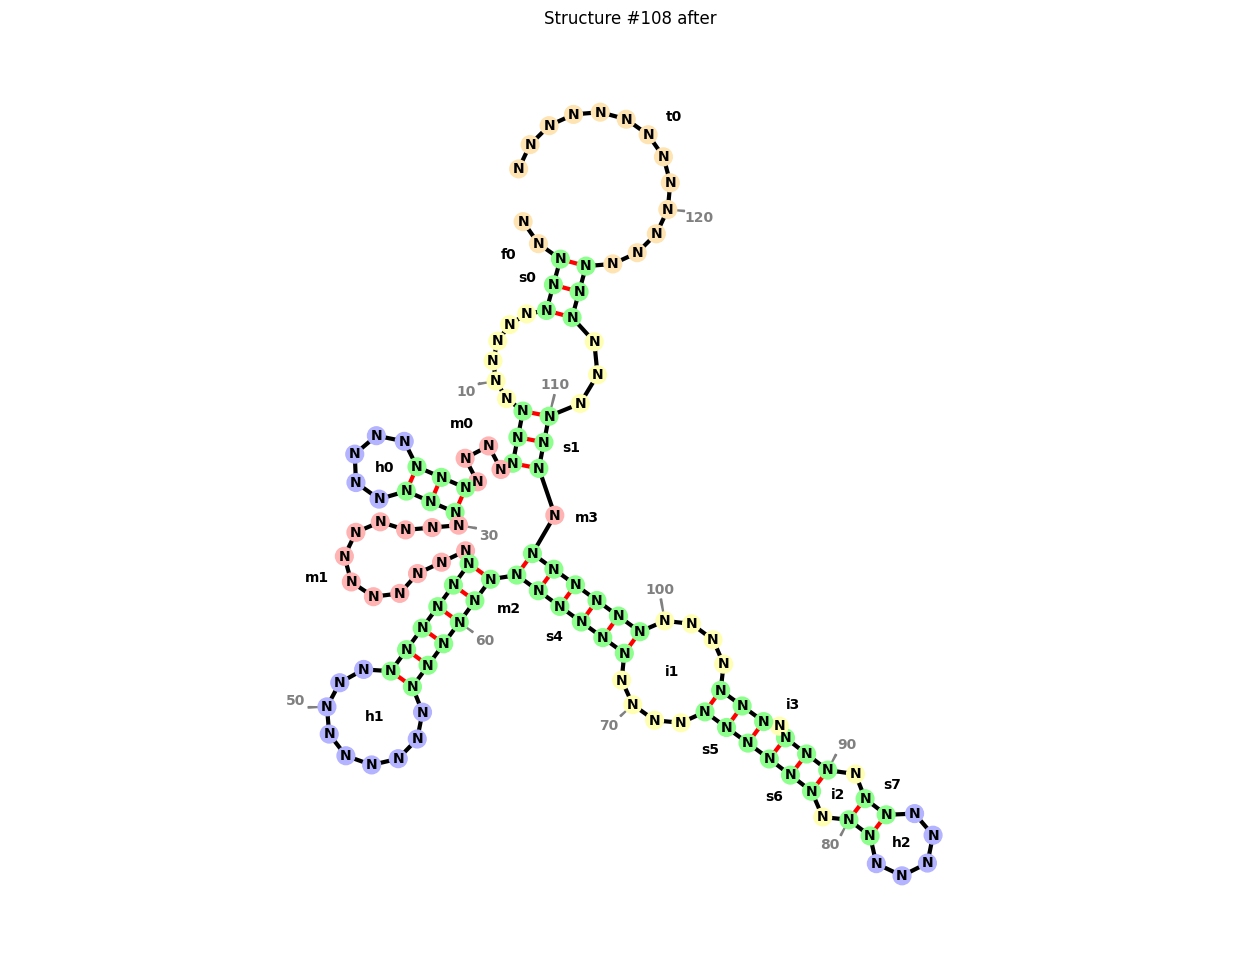

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




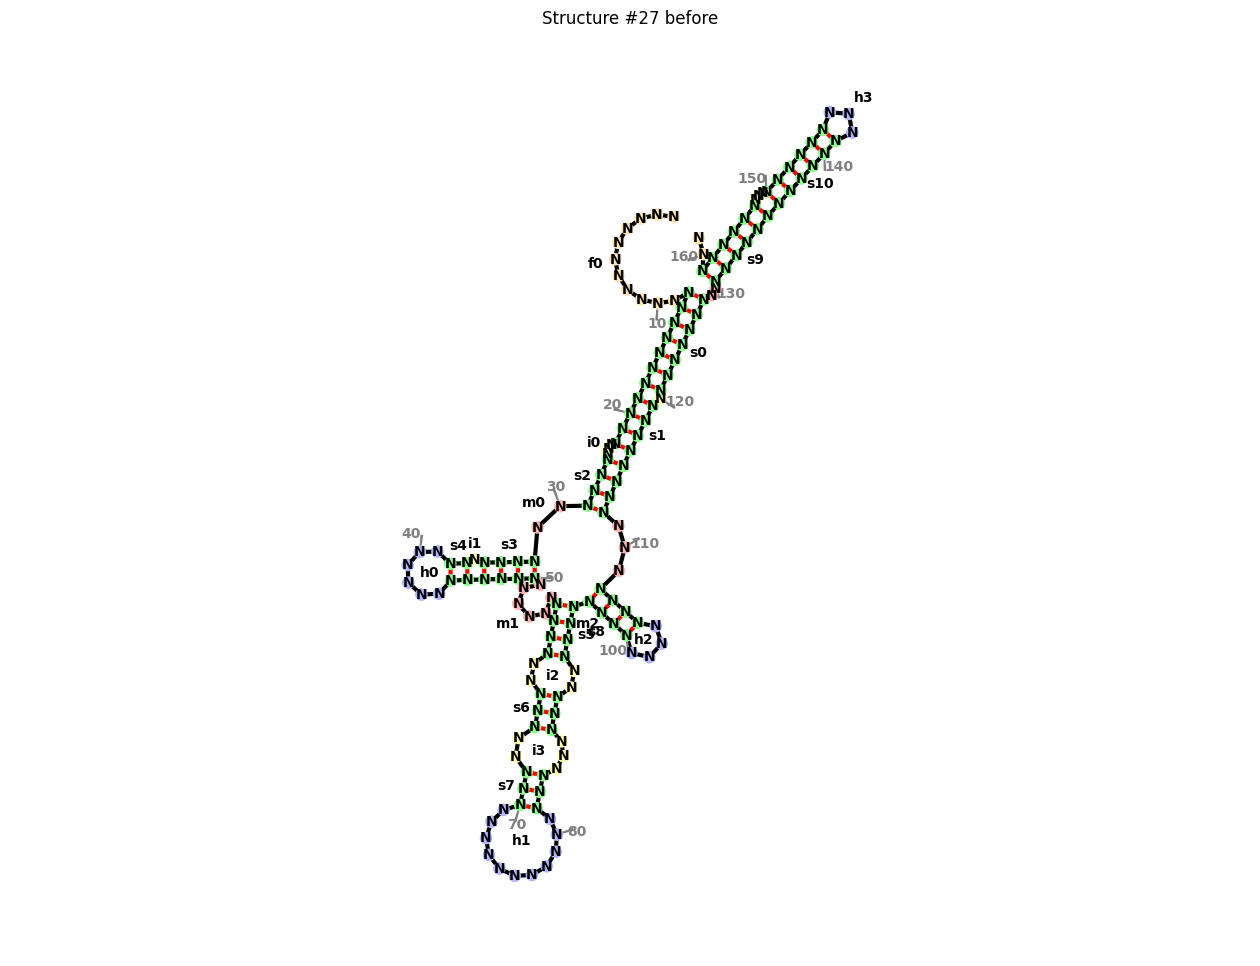

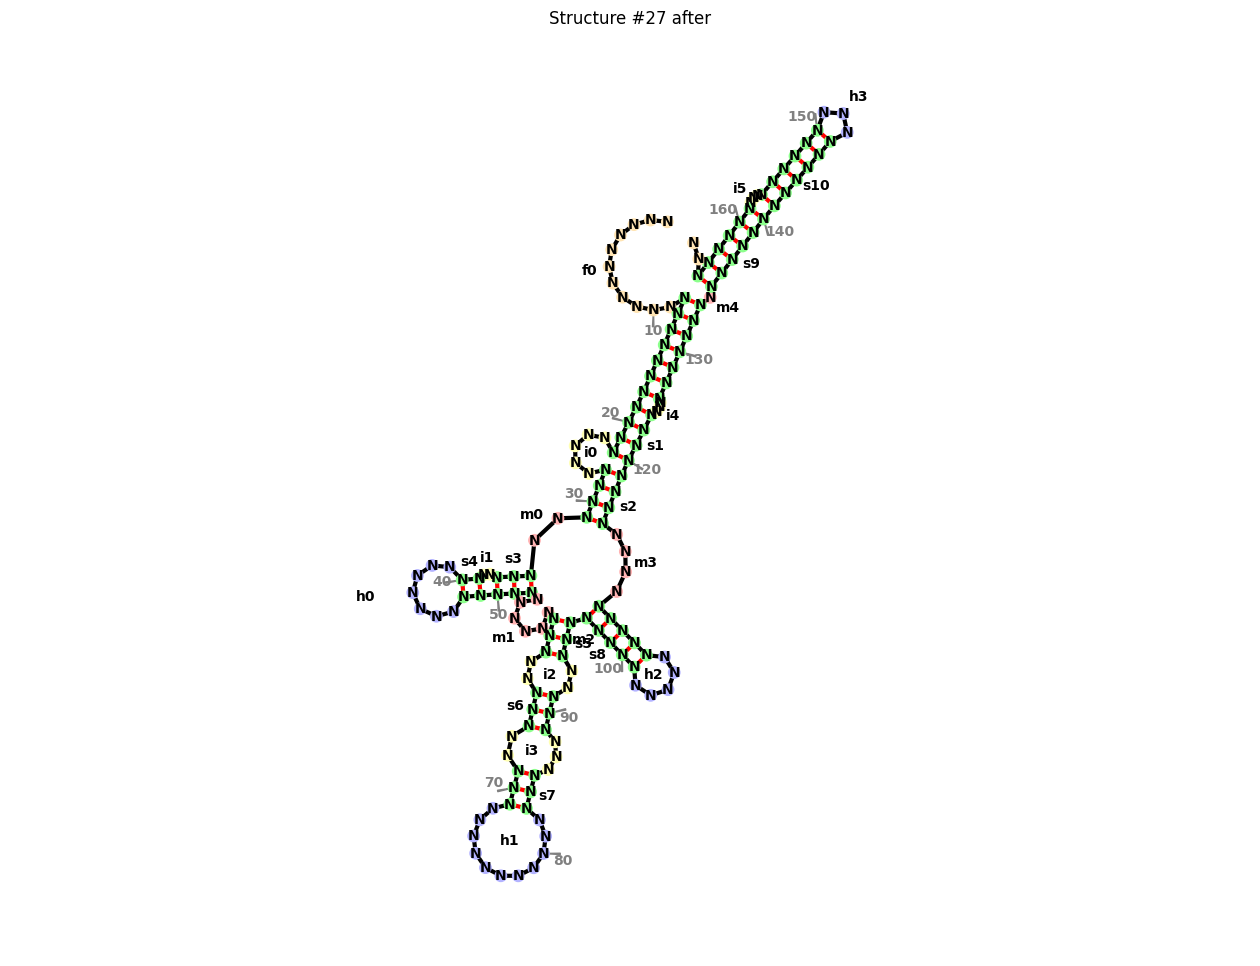

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




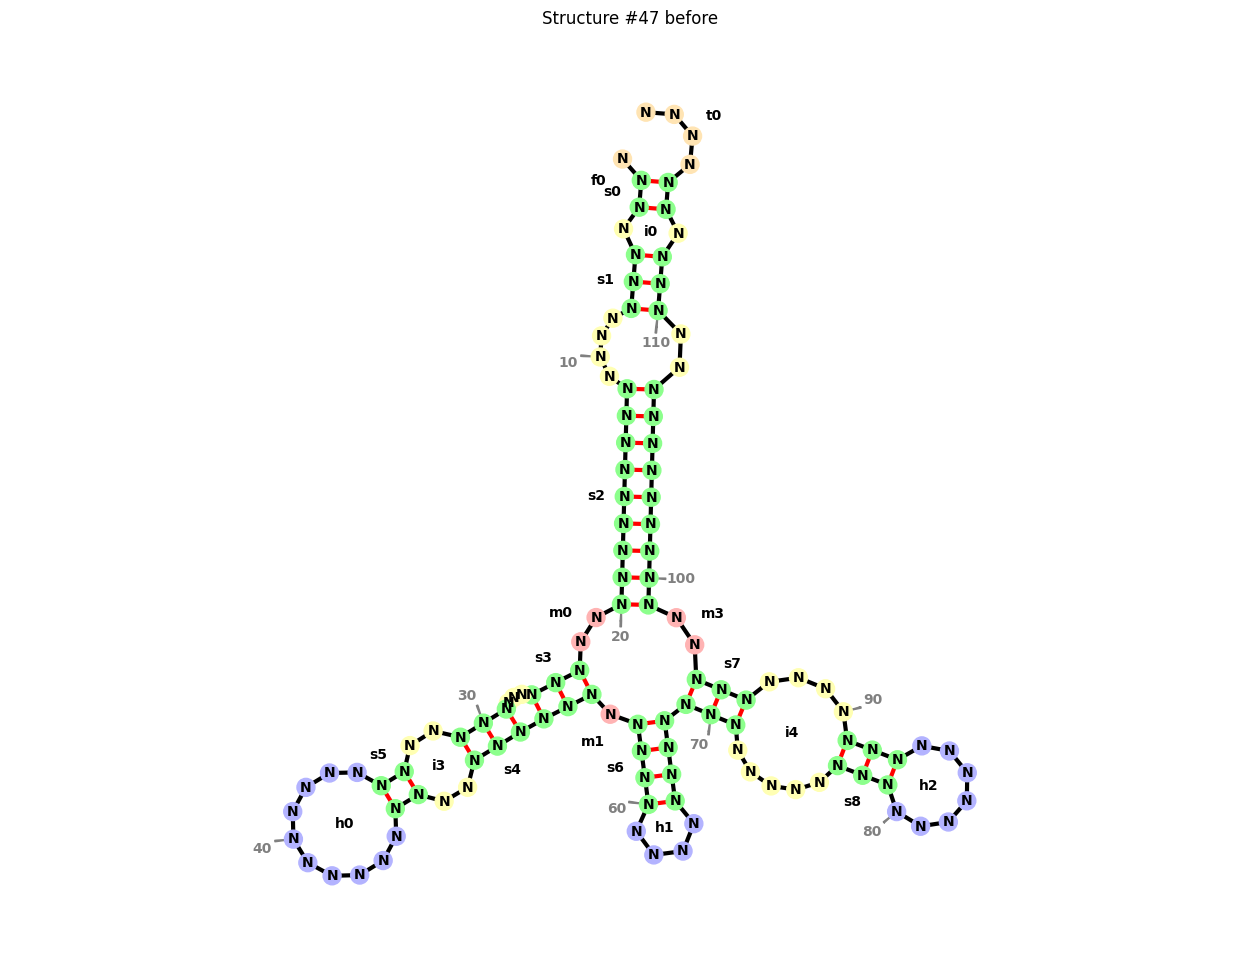

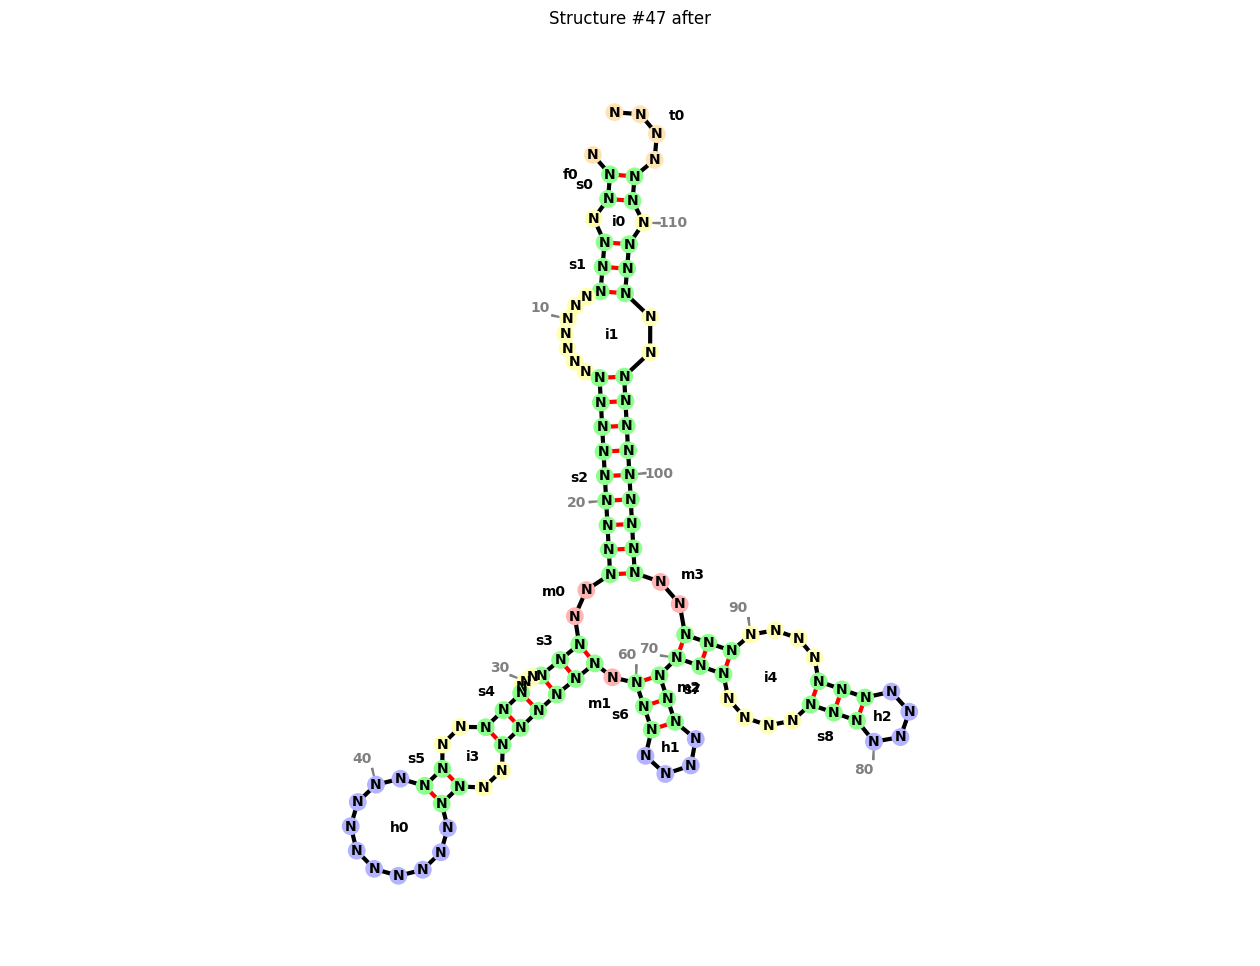

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




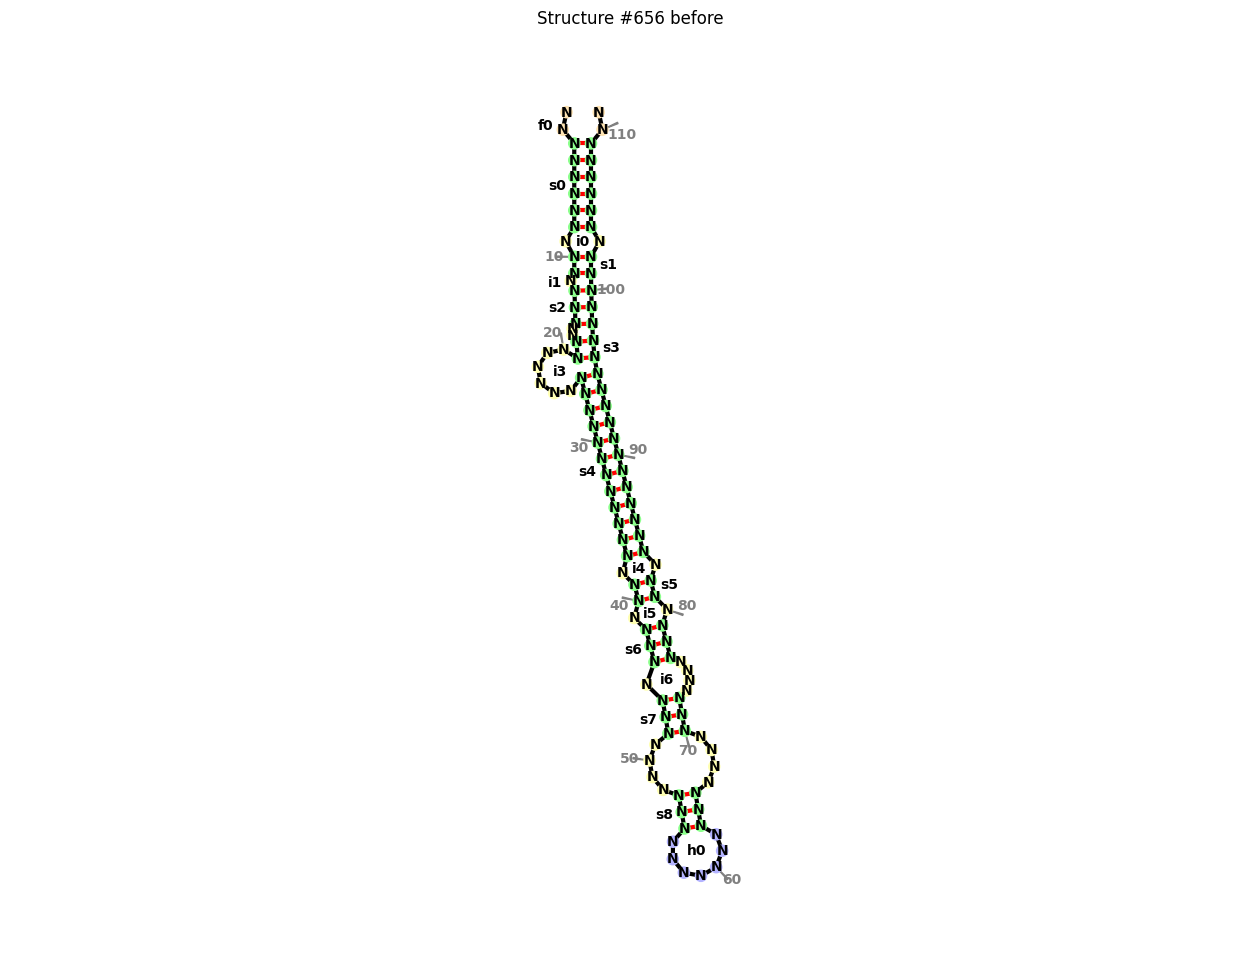

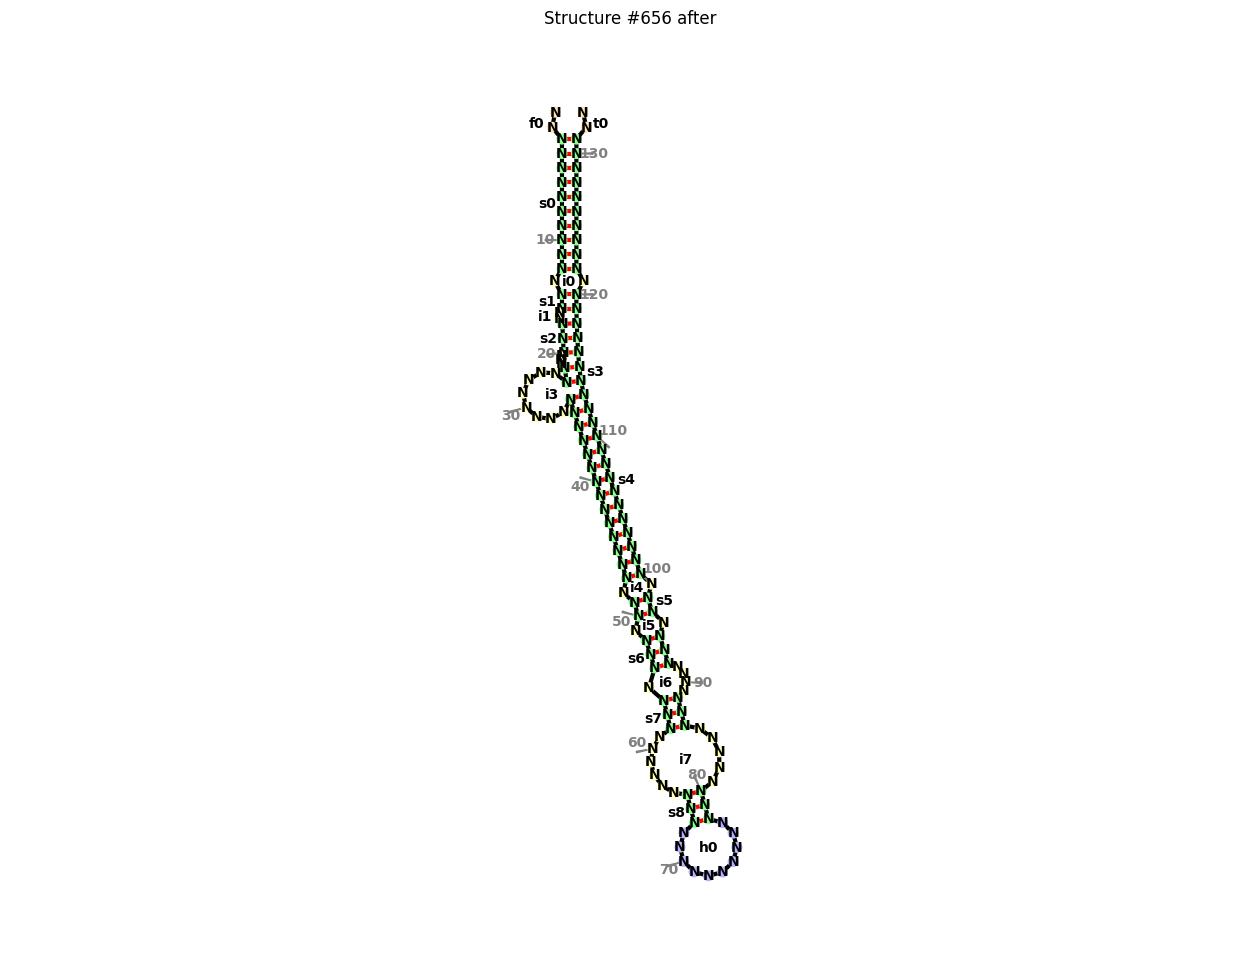

In [ ]:
# @title Plot random sample pair
num_samples = 5 # @param {type:"integer"}

for i in range(num_samples):

  random_sample = random.randint(0, df.shape[0]-1)

  structure_before = df.iloc[random_sample]['structure_A']
  structure_after = df.iloc[random_sample]['structure_P']

  plt.rcParams['figure.figsize'] = [16.0, 12.0]


  cg1 = forgi.load_rna(structure_before, allow_many=False)

  fvm.plot_rna(cg1, text_kwargs={"fontweight":"black"}, lighten=0.7,
              backbone_kwargs={"linewidth":3})
  plt.title('Structure #' +str(random_sample) + ' before')

  plt.show()

  cg2 = forgi.load_rna(structure_after, allow_many=False)
  fvm.plot_rna(cg2, text_kwargs={"fontweight":"black"}, lighten=0.7,
              backbone_kwargs={"linewidth":3})

  plt.title('Structure #' +str(random_sample) + ' after')

  plt.show()

  if i < num_samples -1:
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n')


In [ ]:
# @title Transform structure pairs to compressed contact matrix
def dot_bracket_to_matrix(dot_bracket):
    L = len(dot_bracket)
    contact_matrix = np.zeros((L, L))

    for i_x, base_x in enumerate(dot_bracket):
        if base_x == '(':

            # Finding first closed bracket ahead
            first_closing = dot_bracket[i_x:].find(")")

            # Counting the number of ( between subject ( and first )
            N = dot_bracket[i_x:first_closing+i_x].count('(')

            # To find the ) matching the subject (, we have to search
            # for the (N)th ) ahead of our (
            c = 0
            i_match = 0
            for i_y, base_y in enumerate(dot_bracket[i_x+first_closing:]):
                if base_y == '(':
                    N += 1

                if base_y == ')':
                    c += 1
                    if c == N:

                        i_match =  i_x + first_closing + i_y
                        break

            contact_matrix[i_x, i_match] = 1
            contact_matrix[i_match, i_x] = 1

        else:
            continue

    return contact_matrix.astype(int).tolist()


def compress_matrix(contact_matrix):

    indexes_array = []

    for row in contact_matrix:
        try:
            indexes_array.append(row.index(1))
        except ValueError:
            indexes_array.append(-1)


    return indexes_array

transformed_df = pd.DataFrame(columns=["structure_A", "structure_P", "structure_N"])

with tqdm(total=df.shape[0], desc="Processing") as pbar:
    for index, row in df.iterrows():

        structure_A_matrix = dot_bracket_to_matrix(row.iloc[0])
        structure_A_zip_matrix = compress_matrix(structure_A_matrix)

        structure_P_matrix = dot_bracket_to_matrix(row.iloc[1])
        structure_P_zip_matrix = compress_matrix(structure_P_matrix)

        structure_N_matrix = dot_bracket_to_matrix(row.iloc[2])
        structure_N_zip_matrix = compress_matrix(structure_N_matrix)

        transformed_row = { 'structure_A' : structure_A_zip_matrix,
                            'structure_P' : structure_P_zip_matrix,
                            'structure_N' : structure_N_zip_matrix}

        transformed_df = pd.concat([transformed_df,
                                    pd.DataFrame([transformed_row])],
                                    ignore_index=True)

        del(transformed_row)

        pbar.update(1)

Processing: 100%|██████████| 36000/36000 [04:28<00:00, 134.04it/s]


In [ ]:
# @title Create and download pickle output file
output_pkl_file = 'dummy_RNP_matrices_triplets5pkl' # @param {type:"string"}


transformed_df.to_pickle(output_pkl_file)
print('\nPickle dataset saved in', output_pkl_file)


files.download(output_pkl_file)


Pickle dataset saved in dummy_RNP_matrices_triplets5pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>